# CoronaPlots report

This code focus on readability instead speed. 

> Note, you can remove all filters and others steps by replacing it by a simple loop.

# Downloads
This section needs to be executed by system. You can also use a shell script to do this (Just remove '!' and execute).

```bash
# Download tool to generate pdf Report
pip3 -q install reportlab > /dev/null

# Download tools to login and get spreadsheet
pip3 -q install oauth2client > /dev/null
pip3 -q install gspread > /dev/null

# Download tools to threat data
pip3 -q install pandas > /dev/null
pip3 -q install numpy > /dev/null

# Download tools to plot
pip3 -q install matplotlib > /dev/null
pip3 -q install seaborn > /dev/null


# Download font that will be used
mkdir fonts
curl https://fonts.google.com/download?family=Montserrat -so font.zip
unzip -qq font.zip -d fonts && rm font.zip

# Download Images
#     IMG (Imgur keeps images if 1 view per six months)
#     https://i.imgur.com/vKgu7bE.png --> WomanBlue
#     https://i.imgur.com/GcsTCOp.png --> Default Itabira's logo
wget http://www.clker.com/cliparts/2/a/Q/D/P/J/woman-orange-hi.png -qO girl.png
wget https://i.imgur.com/OnzjeAY.png -qO boy.png
mkdir img && mv boy.png img/boy.png && mv girl.png img/girl.png
wget https://i.imgur.com/ef1IAWY.jpg -qO img/logo.png

# Create folder to store pdf
mkdir pdfs/
mkdir logs/
```

In [1]:
# -*- coding: utf-8 -*-
%config IPCompleter.greedy=True

---
# Getting current date

In [2]:
# pytz.all_timezones to see all timezones
from pytz import timezone # Defaul timezone it's ahead of Brasil(+)
from datetime import datetime

# Note that changing linux localtime, doesn't affect Python
BRASIL_TZ = timezone('America/Campo_Grande')
DAY, MONTH, YEAR = datetime.now(BRASIL_TZ).strftime("%d %m %Y").split()

def getMonthName(month, startUpper=False):
  '''
  Need it when execute in different system's locale.
  
  Parameter
  ---------
  startUpper: (boolean)
    Force to fst letter be upper.

  Return
  ------
    (string) Month's names.
  '''
  month = int(month)
  monthName = ['janeiro',
               'fevereiro',
               'março',
               'abril',
               'maio',
               'junho',
               'julho',
               'agosto',
               'setembro',
               'outubro',
               'novembro',
               'dezembro'
  ]
  month = monthName[month-1]
  m_up = month[0].upper() + month[1:]

  return month if not startUpper else m_up 

# Get month's name
MONTH_NAME = getMonthName(MONTH, True)

# Starting logging
[See this tip 'bout logging](https://docs.python.org/3/library/logging.html#logrecord-attributes)

In [3]:
import logging as log
log.basicConfig(
    format='[%(asctime)s] : %(levelname)s: %(funcName)s : %(message)s', 
    datefmt='%H:%M:%S',
    filename='logs/LOG_{}-{}-{}.log'.format(YEAR,MONTH,DAY),
    level=log.INFO)
log.info('Logging created w/ success!')
log.debug('Default timezone: {}'.format(BRASIL_TZ))

# 1 Login and Sheet load

[O2auth (in use)](https://gspread.readthedocs.io/en/latest/oauth2.html) client.
To use Google's API, you'll need to allow Google API in **[Google console](https://console.developers.google.com/iam-admin/projects)**. Also, you'll must create an business account too. 

## 1.1 Login

In [4]:
from oauth2client.service_account import ServiceAccountCredentials as Credentials
import gspread # Sheets

# Login Constants
SCOPE = [
         'https://spreadsheets.google.com/feeds', 
         'https://www.googleapis.com/auth/drive'
]
URL = 'https://docs.google.com/spreadsheets/d/1YERxbIO0VgnVLElEgFxsv_Hr2ra6nHuPVUUGx6OVds4/edit?usp=sharing'

# Create an Client
GAUTH = Credentials.from_json_keyfile_name('nisis_credentials.json',SCOPE)
# Auth the client
GCLIENT = gspread.authorize(GAUTH)

In [5]:
log.info('Client acquired with success!')

## 1.2 Sheet Load

In [184]:
import pandas as pd
from numpy import nan as NaN
import numpy as np

def getSheetsNames(URL, gc):
  '''
  Get all tab's names from url (sheet)
  
  Parameters
  ----------
  URL: (str)
    Url's sheet
  gc: (GoogleClient)
    Google client from gspread autenticated.

  Return
  ------
    (list) Sheet's tab names.
  '''
  workSheets = GCLIENT.open_by_url(URL)
  sheetsNames = [i.title for i in workSheets.worksheets()] # sheets names
  return sheetsNames


def getSheetValue(sheet_name, URL, gc, debug=False):
  '''
  Get pandas DF from sheet_name in WorkSheets. 
  
  Parameters
  ----------
  sheet_name: (string)
    Name of sheet

  Return
  ------
  (DataFrame) 2Dimensional sheet got it from one tab.

  Examples
  --------
    >> all_dfs = list(map(getSheetValue,sheets))
    >> list(map(lambda x: x.columns, all_dfs) )
    >> df = pd.concat(all_dfs)
  '''
  wb    = GCLIENT.open_by_url(URL) # client open this url
  sheet = wb.worksheet(sheet_name) # get value(tab) settled from cell above
  data  = sheet.get_all_values() # get csv content from spreadsheet
  df    = pd.DataFrame(data) # convert csv into DataFrame 

  df.columns = df.iloc[0] # Remove Id's columns (They're in fst row)
  df = df.iloc[1:] # Ignore fst row
  
  # If we have an empty column
  df.dropna(axis='columns')
  # If we have an empty row
  df.dropna(axis='rows')
  # Drop fst column (Index)
  df.drop(df.columns[0], axis=1, inplace=True)

  if debug:
    log.debug('Sem situação: ', len(list(
      filter(lambda x: type(x) is not str, df['Selecione a situação:']))))


  ############################  Treating data ##################################
  # Renaming columns
  #   We rename column by column, 'cause if we do in this way, we won't have
  #   problems with insertion of new columns. If we made this by replacing columns
  #   list to a new one.
  df.rename(columns={'Selecione a situação:': "Situation"}, inplace=True)
  df.rename(columns={'Escolha a situação do caso confirmado:':"SituationOfConfirmed"}, inplace=True)
  df.rename(columns={'Identificador:': "Id"}, inplace=True)
  df.rename(columns={'Está monitorado pela central de vigilância da saúde? ': 'Monitoring'}, inplace=True)
  df.rename(columns={'Houve internação?':'IsInterned'}, inplace=True)
  df.rename(columns={'Sexo:':'Gender'}, inplace=True)
  df.rename(columns={'Idade:':'Age'}, inplace=True)
  df.rename(columns={'Bairro:':'Neighboorhood'}, inplace=True)
  df.rename(columns={'Leito:':'HospitalClassifier'}, inplace=True)
  df.rename(columns={'Escolha a situação do caso descartado:':'Discarted'}, inplace=True)
  df.rename(columns={'Fatores de risco:':'RiskFactors'}, inplace=True)
  df.rename(columns={'Semana epidemiológica':'EpidemicWeek'}, inplace=True)

  # Remove where Situation is empty -- In this dataframe, empty means that are duplicate
  _filter = df['Situation'] != ''
  df = df[_filter]
  
   # Convert to lower. We do this to minimize possible errors when making a string compare.
  df['Situation'] = df['Situation'].str.lower()
  df['Monitoring'] = df['Monitoring'].str.lower()
  df['SituationOfConfirmed'] = df['SituationOfConfirmed'].str.lower()
  df['HospitalClassifier'] = df['HospitalClassifier'].str.lower()
  df['Gender'] = df['Gender'].str.lower()
  df['RiskFactors'] = df['RiskFactors'].str.lower()
    
  # Fix: NBH (empty and Spaced)
  df['Neighboorhood'] = df['Neighboorhood'].str.strip() # Spaced
  _filter = df['Neighboorhood'] == ''
  df.loc[_filter, 'Neighboorhood'] = 'Sem Bairro' # Empty

  # Fix: Convert str ages to int
  _filter = df['Age'] == ''
  df.loc[_filter, 'Age'] = 0 # put 0 in empty ages
  df['Age'] = df['Age'].apply(lambda x: int(x)) # convert to int

  # Fix: RiskFactors (empty and Spaced)
  df['RiskFactors'] = df['RiskFactors'].str.strip() # Spaced
  _filter = df['RiskFactors'] == ''
  df.loc[_filter, 'RiskFactors'] = 'Não tem' # Empty

  # Fix: Put N/A identifier in EpidemicWeek
  _filter = np.array( df['EpidemicWeek'].str.isdigit(), dtype=np.bool)
  df.loc[~_filter, 'EpidemicWeek'] = '#N/A' # Empty or #N/A
  df.loc[_filter, 'EpidemicWeek'] = df.loc[_filter, 'EpidemicWeek'].apply(lambda x: int(x)) # Convert to int where is a number

  df = df.reset_index(drop=True) # Drop removes old indexation 

  return df

In [88]:
# Getting results
sheetName = "{}-{}-{}".format(DAY,MONTH,YEAR)
df = getSheetValue(sheetName, URL, GCLIENT)

log.info('Tab "{}" oppened with success!'.format(sheetName))

# 2 Image and Copy Imports

In [41]:
# To import image in reportlab. Images are Pillow formats or BytesIO
from reportlab.lib.utils import ImageReader

from PIL import Image # Open png images
from copy import deepcopy as dp # dataframe creation and manipulation permanent

# 3 Load Images

In [42]:
def alpha2white(img):
  # Create a white rgb background
  _img = Image.new("RGBA", img.size, "WHITE") 
  _img.paste(img, (0, 0), img)
  _img.convert('RGB')
  return _img.transpose(Image.FLIP_LEFT_RIGHT)

# Draw method aim's to use ImageReader or path to object
# we don't use here, 'cause of black background if alpha is 1
boy  = ImageReader( alpha2white(Image.open('img/boy.png').rotate(180)) )
girl = ImageReader( alpha2white(Image.open('img/girl.png').rotate(180)) )
logo = ImageReader( Image.open('img/logo.png').rotate(180).transpose(Image.FLIP_LEFT_RIGHT) )
# It's necessary rotate because PIL inverted.

# 4 Graphic data

> In _Google sheets_ you can use COUNTIF functions to count ocurrences in a column:
>```xls
=COUNTIF(T1:T2000;"SUSPEITO")
```

In [221]:
def similar(word1, word2, accept=False, caseSensitive=False, method='BuiltIn'):
  '''
  This method check similarity between strings. It can be used with
  two ways. Using built-in method or leveinshtein implementation by
  Antti Haapala. If use leveinshtein, need to
        >>> pip install python-Levenshtein  
  See
  ---
    https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html
  
  Parameters
  ----------
  word1: (string) To compare
  word2: (string) To compare
  accept: (int) If 0 will return percentual, else return true for value in percent
  caseSensitive: (bool) Set false to disable
  method: (string) 'BuiltIn' or 'Levenshtein'

  Return
  ------
  Similarity in percentual if accept is False, otherwise,
  True for percentual > accept
  '''

  if not caseSensitive:
    word1 = word1.lower()
    word2 = word2.lower()
  
  if method == 'BuiltIn':
    from difflib import SequenceMatcher
    percent = SequenceMatcher(None, word1, word2).ratio()
    return percent if not accept else percent>=accept

  elif method == 'Levenshtein':
    from Levenshtein import ratio
    percent = ratio(word1, word2)
    return percent if not accept else percent>=accept

  else:
    raise(Exception('Method not implemented.'))

def applyFilter(df, l, word, col):
    '''
    Check in "col" of "l" situation, the amount of word who matches with "word" 
      with 0.7 similarity.

    Parameters
    ----------
    df: (DataFrame) Data to analysis
    l: (list) Bitset with lines to analysis.
    word: (string) Word to analysis
    col: (string) Column to search for.
    
    Return
    ------
    (int) Amount of ocurrences.

    Example
    -------
    >> df = pd.DataFrame(['teste']*8, columns={'c1'})
            col1
      * 0	1.0
      * 1	1.0
      * 2	1.0
        3	1.0
        4	1.0
        5	1.0
        6	1.0
      * 7	1.0
    >> applyFilter(df, 3*[1]+4*[0]+[1], 'teste', 'c1')
        4
    >> 3*[1]+4*[0]+[1] == [1 1 1 0 0 0 0 1]
    '''

    def getValue(x):
      if type(x) is not str:
        return 0
      else:
        return similar(x,word,0.7)

    return int(len(list( filter(getValue, df.loc[l, col]) )))

In [266]:
# To be clear in variable manipulation, every var in this section will have
# an d2a_ prefix (data to analysis). If it's a const will be UPPER_CASE

AGES = [
    'Não informado', 
    '1 a 9', 
    '10 a 19', 
    '20 a 29', 
    '30 a 39', 
    '40 a 49', 
    '50 a 59',
    '>= 60'
]

DISEASES = [
    'Doenças respiratórias crônicas descompensadas',
    'Doenças cardíacas crônicas',
    'Diabetes',
    'Doenças renais crônicas em estágio avançado (graus 3,4 e 5)',
    'Imunossupressão',
    'Gestantes de alto risco',
    'Portadores de doenças cromossômicas ou em estados de fragilidade imunológica (ex:.Síndrome de Down)',
    'Não tem',
    'Outros'
]

# Vector of positions in dataframe corresponding to situations
d2a_vConfirmed   = np.array( df['Situation']=='confirmado', dtype=np.bool )
d2a_vDunderI     = np.array( df['Situation']=='obito em investigação', dtype=np.bool ) # deaths under investigation
d2a_vSuspect     = np.array( df['Situation']=='suspeito', dtype=np.bool ) | d2a_vDunderI
d2a_vAnalysis    = np.array( df['Situation']=='baixa probabilidade', dtype=np.bool )
d2a_vDiscarted   = np.array( df['Situation']=='descartado', dtype=np.bool )
d2a_vOsituations = ~(d2a_vConfirmed | d2a_vDunderI | d2a_vSuspect | d2a_vAnalysis | d2a_vDiscarted) # other situations
d2a_vInterned    = np.array( df['Monitoring']=='internado', dtype=np.bool ) # That still are interned
d2a_vMonitoring  = np.array( df['Monitoring']=='sim', dtype=np.bool ) # Note that we don't count d2a_Interned

# Total of ..
d2a_TofConfirmed = int(len(list(filter(None, d2a_vConfirmed))))
d2a_TofDiscarted = int(len(list(filter(None, d2a_vDiscarted))))
d2a_TofSuspect   = int(len(list(filter(None, d2a_vSuspect))))
d2a_TofAnalysis  = int(len(list(filter(None, d2a_vAnalysis))))
d2a_TofInterned  = int(len(list(filter(None, d2a_vInterned))))
d2a_TofDunderI   = int(len(list(filter(None, d2a_vDunderI)))) # Total of deaths under inestigation

# Total of Confirmed in ..
d2a_TofCnursery  = applyFilter(df, d2a_vInterned&d2a_vConfirmed,'enfermaria','HospitalClassifier') # Confirmed in nursery
d2a_TofCuti      = applyFilter(df, d2a_vConfirmed,'ti','HospitalClassifier') # Check why there's a case without be interned
d2a_TofCrecover  = applyFilter(df, d2a_vConfirmed,'recuperado','SituationOfConfirmed')
d2a_TofChome     = applyFilter(df, d2a_vConfirmed,'amento domiciliar','SituationOfConfirmed')
d2a_TofCdead     = applyFilter(df, d2a_vConfirmed,'óbito','SituationOfConfirmed')

# Total of Suspects monitoring
d2a_TofSmonitor  = int(len(list( filter(None, d2a_vMonitoring & d2a_vSuspect) )))

# Total of Discarted deaths
d2a_TofDdeaths   = applyFilter(df, d2a_vDiscarted,'óbito','Discarted')

# Total of Suspects in hospital (uti or nursery)
# This is a peculiar caracteristic of this sheet. The Interned indicates that still in.
d2a_TofSnursery   = applyFilter(df, d2a_vInterned,'enfermaria','HospitalClassifier')
d2a_TofSuti       = applyFilter(df, d2a_vInterned,'uti','HospitalClassifier')

# Total of Analysis where gender is ..
d2a_TofAfemale    = applyFilter(df, d2a_vAnalysis,'f','Gender')
d2a_TofAmale      = applyFilter(df, d2a_vAnalysis,'m','Gender')

# Total of Suspects were gender is ..
d2a_TofSfemale    = applyFilter(df, d2a_vSuspect,'f','Gender')
d2a_TofSmale      = applyFilter(df, d2a_vSuspect,'m','Gender')

# Total of Confirmed were gender is ..
d2a_TofCfemale    = applyFilter(df, d2a_vConfirmed,'f','Gender')
d2a_TofCmale      = applyFilter(df, d2a_vConfirmed,'m','Gender')

# Create Vectors of Ages corresponding of situations
d2a_vSage         = [0]*len(AGES) # Suspect ages
d2a_vCage         = [0]*len(AGES) # Confirmed
d2a_vAage         = [0]*len(AGES) # Analysis

# Give a vector position according to AGES list
def ageRange(age):
    if age<1: return 0
    if age>=1 and age<10: return 1
    if age>=10 and age<20: return 2
    if age>=20 and age<30: return 3
    if age>=30 and age<40: return 4
    if age>=40 and age<50: return 5
    if age>=50 and age<60: return 6
    return 7

# Convert to percent
def percentage(number, total):
    return round(number*100/total, 1)

# Total of Confirmed according with diseases (in percentage)
d2a_TofCdiseases  = [applyFilter(df, d2a_vConfirmed, it,'RiskFactors') for it in DISEASES]
_aux              = sum(d2a_TofCdiseases)
d2a_TofCdiseases  = [percentage(it,_aux) for it in d2a_TofCdiseases]

# Total of (Suspects and Confirmed) according with diseases (in percentage)
d2a_TofCSdiseases = [applyFilter(df, d2a_vConfirmed | d2a_vSuspect, it,'RiskFactors') for it in DISEASES]
_aux              = sum(d2a_TofCSdiseases)
d2a_TofCSdiseases = [percentage(it,_aux) for it in d2a_TofCSdiseases]

# Week
d2a_vCSweekName = list(set(df['EpidemicWeek']))
d2a_vCSweekName.remove('#N/A') # With this we force '#N/A' to be the first in list
d2a_vCSweekName = ['#N/A'] + d2a_vCSweekName # we use this trick to force positions below
d2a_vCSweekValue = [0]*len(d2a_vCSweekName) # same idea as ages


# Populate vectors of week and ages
for it in df.index:
    if d2a_vSuspect[it]:
        d2a_vSage[ ageRange( df.loc[it,'Age'] ) ] += 1
        _week = df.loc[it, 'EpidemicWeek']
        if _week =='#N/A':
            _week = 0
        # force position from set above (start to count at 10th week)
        d2a_vCSweekValue[_week-9 if _week>0 else 0] += 1

    if d2a_vConfirmed[it]:
        d2a_vCage[ ageRange(df.loc[it,'Age']) ] += 1
        _week = df.loc[it, 'EpidemicWeek']
        if _week =='#N/A':
            _week = 0
        # Note that week value to"1'\n".strip()ok both situations.
        d2a_vCSweekValue[_week-9 if _week>0 else 0] += 1
        
    if d2a_vAnalysis[it]:
        d2a_vAage[ ageRange(df.loc[it,'Age']) ] += 1


# 5 Plots

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns # Change color plot
from io import BytesIO # Image buff

sns.set_style('darkgrid')

def barPlot(x,y, siz, palette="Oranges"):
  fig = plt.figure( figsize=siz )
  
  plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      labelbottom=False) # labels along the bottom edge are off
  ax = sns.barplot(x=x, y=y, palette=palette)
  
  _currSpace = ax.get_xticks()
  _currSpace = _currSpace[1] - _currSpace[0]
  plt.xticks(np.arange(0, max(x)+_currSpace, _currSpace))

  # Create annotions marks using total amount of infected
  maxX = max(x)
  _y = 0
  for i in x:
      ax.text(i + maxX/100, _y, str(i))
      _y+=1
  
  

  fig.tight_layout() # Remove extra paddings
  # Convert fig img to buffer img
  buff =  BytesIO()
  fig.savefig(buff, format='PNG')
  buff.seek(0)
  buff = Image.open(buff).rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
  return ImageReader( buff )


def linePlot(y,x, siz,palette="Oranges"):
  fig = plt.figure( figsize=siz )
  plt.plot(x,y, marker='o', color='darkred', linewidth=2, markersize=12)
  # sns.set_palette(palette)

  fig.tight_layout() # Remove extra paddings
  # Convert fig img to buffer img
  buff =  BytesIO()
  fig.savefig(buff, format='PNG')
  buff.seek(0)
  buff = Image.open(buff).rotate(180).transpose(Image.FLIP_LEFT_RIGHT)
  return ImageReader( buff )

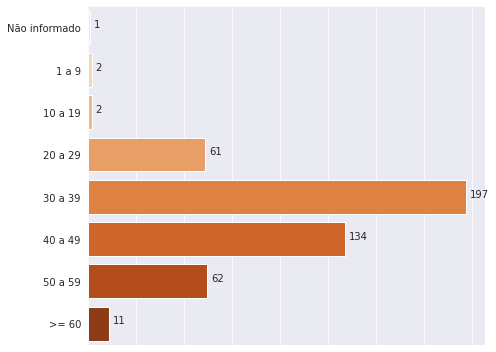

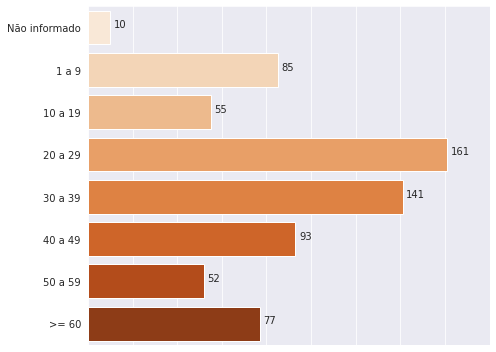

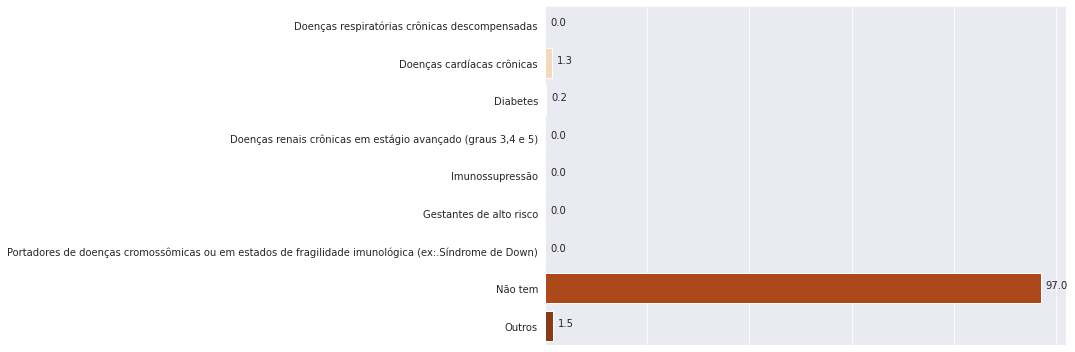

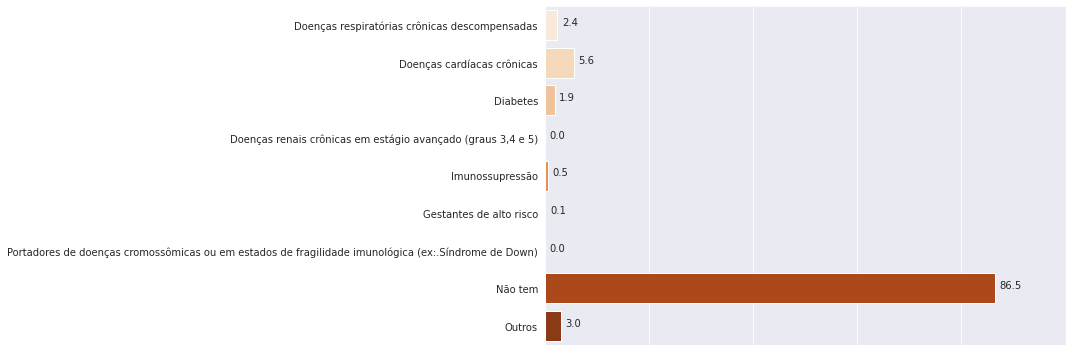

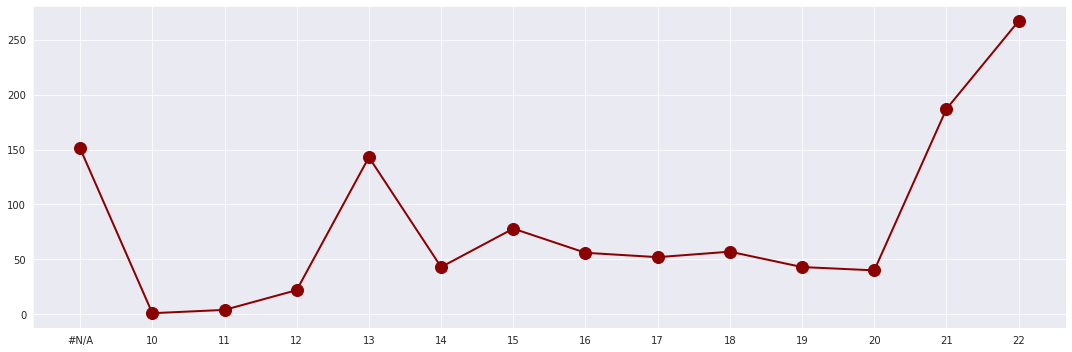

In [224]:
# Generating
graphic_C           = barPlot(d2a_vCage, AGES, (7,5))
graphic_S           = barPlot(d2a_vSage, AGES, (7,5))
graphic_Cdiseases   = barPlot(d2a_TofCdiseases, DISEASES, (15,5))
graphic_CSdiseases  = barPlot(d2a_TofCSdiseases, DISEASES, (15,5))
graphic_CSweek      = linePlot(d2a_vCSweekValue, d2a_vCSweekName, (15,5))

# 6 PDF Report

## 6.1 Imports

In [225]:
from reportlab import __version__
# Canvas are used to draw in pdf (When U won't to create a document template)
from reportlab.pdfgen import canvas
# Tool to create colors models in reportlab. Colors as weel
from reportlab.lib import colors as rlabColors
# Tools to import family fonts
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

## 6.2 Font family and others settings

In [226]:

################ Font family and Colors ########################
pdfmetrics.registerFont(TTFont('Montserrat','fonts/Montserrat-'+'Regular.ttf'))
pdfmetrics.registerFont(TTFont('Montserratb','fonts/Montserrat-'+'Bold.ttf'))
pdfmetrics.registerFont(TTFont('Montserrati','fonts/Montserrat-'+'Italic.ttf'))
pdfmetrics.registerFont(TTFont('Montserratbi','fonts/Montserrat-'+'BoldItalic.ttf'))
pdfmetrics.registerFontFamily(
    'Montserrat',
    normal='Montserrat',
    bold='Montserratb',
    italic='Montserrati',
    boldItalic='Montserratbi')

# Colors not def'ed in rlabColors
myColors = {
    'HeadOrange': rlabColors.toColor('rgb(209,64,19)'),
    'Head2Orange': rlabColors.toColor('rgb(255,160,153)'),
    'HeadBlue': rlabColors.toColor('rgb(20,13,93)'),
    'Head2Blue': rlabColors.toColor('rgb(0,171,153)'),
    'BlueGray': rlabColors.toColor('rgb(195,210,231)'),
    'Green':  rlabColors.toColor('rgb(179,111,90)'),
    'GreenD':  rlabColors.toColor('rgb(0,255,0)'),
    'BlueFB': rlabColors.toColor('rgb(9,37,83)'),
    'IceWhite': rlabColors.toColor('rgb(233,233,233)')
} 

## 6.3 Default configs

In [227]:
keywords = ['PDF report','Corona', 'Corona vírus', 'vírus', 'COVID19']
progVers = '2.0'
author   = 'Pedro Augusto C Santos'
subject  = 'NISIS - SMS de Itabira'
creator  = 'ReportLab v'+__version__
producer = 'www.reportlab.com'

xPos = 0
yPos = 0
page = '' # just to initialize the variable

# To the settings before I just need a way to propagate changes
# without rewrite everything. Furthermore, I'm using the characteristics
# of python, to search variables defined before to minimize the number of
# parameters that I would to put in Class, or either in a function.

## 6.4 Start

In [228]:
def pdf_Start(fileName):
    global pgDim, xPos, yPos, page

    xPos = 0
    yPos = 0

    page = canvas.Canvas(
        fileName,
        pagesize=(pgDim['w'],pgDim['h']),
        bottomup = 0,
        pageCompression=0,
        verbosity=0,
        encrypt=None
    )
    page.setProducer(producer)
    page.setKeywords(keywords)
    page.setCreator(creator)
    page.setAuthor(author)
    page.setSubject(subject)

## 6.5 Title

In [229]:
def setTitle(t):
    global page
    
    page.setTitle(t)
    page.setFillColor(rlabColors.white)

## 6.6 Header

In [230]:
def putHeader(c1, c2):
    global page, yPos

    # Header
    page.setFillColor(myColors[c1])
    page.rect(0,0,pgDim['w'], 148, stroke=0, fill=1)
    # Sub header
    page.setFillColor(myColors[c2])
    page.rect(0,148,pgDim['w'], 47, stroke=0, fill=1)

    page.setFont("Montserrat",36)
    page.setFillColor(rlabColors.white)
    page.drawCentredString(
        pgDim['w']/2, 
        105.2,
        "BOLETIM EPIDEMIOLÓGICO"
    )

    page.setFont("Montserrat",13)
    page.drawCentredString(
        pgDim['w']/2,
        130.6,
        "COVID-19: Doença causada pelo Novo Coronavírus"
    )

    page.setFont("Montserratb",13)
    page.drawString(
        13, 
        173.6,
        "{} de {} de {}".format(DAY,MONTH_NAME,YEAR)
    )

    page.drawString(
        570, 
        173.6,
        "Secretaria de Saúde de Itabira"
    )

    yPos = 200 # 195 
    # Before this point, everything must use yPos parameter to position Y coords


## 6.7 Emphasis

In [231]:
def putEmphasis():
    global page, yPos

    def dots(page, x, y, s, k):
        i,j = 1,0
        while i <= s:
            page.circle(x, y + 8*i, 2, stroke=0, fill=1)
            i+=1
        while j <= k:
            page.circle(x + 8*j, y + 8*i, 2, stroke=0, fill=1)
            j+=1
        
    # Rectangles and Dots (LEFT)
    page.setFillColor(myColors['BlueFB'])
    page.roundRect(14, yPos + 75,219, 112, 15, 0, 1)
    dots(page, 50, yPos + 187, 6, 1)
    dots(page, 50, yPos + 235, 6, 1)
    dots(page, 50, yPos + 235+48, 11, 1)
    page.setFont('Montserrat',18)
    page.drawString(115, yPos + 239,'PESSOA(S) EM')
    page.drawString(115, yPos + 255,'MONITORAMENTO')
    page.drawString(115, yPos + 285, 'PESSOA(S)')
    page.drawString(115, yPos + 301, 'HOSPITALIZADA(S)')
    page.drawString(115, yPos + 239+48+88,'ÓBITO(S) EM')
    page.drawString(115, yPos + 255+48+88,'INVESTIGAÇÃO')
    page.setFont('Montserrat',32)
    page.drawCentredString(85, yPos + 251, str(d2a_TofSmonitor))
    page.drawCentredString(85, yPos + 300, str(d2a_TofSnursery + d2a_TofSuti))
    page.drawCentredString(85, yPos + 300+88, str(d2a_TofDunderI))
    page.setFont('Montserrat',18)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(108, yPos + 327, str(d2a_TofSnursery))
    page.drawCentredString(108, yPos + 345, str(d2a_TofSuti))
    page.setFont('Montserrat',12)
    dots(page, 80, yPos + 300, 2, 1)
    dots(page, 80, yPos + 316, 2, 1)
    page.drawString(98+20, yPos + 325, 'enfermaria')
    page.drawString(98+20, yPos + 343, 'em UTI')

    # Rectangles and DOTS (MIDDLE)
    page.setFillColor(rlabColors.red)
    page.roundRect(288, yPos + 75, 219, 112, 15, 0, 1)
    dots(page, 330, yPos + 187, 4, 4)
    dots(page, 330, yPos + 187, 8, 4)
    dots(page, 330, yPos + 187, 12, 4)
    dots(page, 330, yPos + 187, 16, 4)
    dots(page, 330, yPos + 187, 20, 4)
    page.setFont('Montserrat',32)
    page.drawCentredString(395, yPos + 240, str(d2a_TofCrecover))
    page.drawCentredString(395, yPos + 270, str(d2a_TofChome))
    page.drawCentredString(395, yPos + 300, str(d2a_TofCdead))
    page.drawCentredString(395, yPos + 335, str(d2a_TofCnursery))
    page.drawCentredString(395, yPos + 365, str(d2a_TofCuti))
    page.setFont('Montserrat',12)
    page.setFillColor(rlabColors.gray)
    page.drawString(428, yPos + 230, 'recuperado(s)')
    page.drawString(428, yPos + 255, 'em isolamento domiciliar') #
    page.drawString(448, yPos + 268, 'monitorado')               #
    page.drawString(428, yPos + 293, 'óbito(s) confirmado(os)')
    page.drawString(428, yPos + 325, 'hospitalizado(s) em enfermaria')
    page.drawString(428, yPos + 355, 'hospitalizado(s) em CTI em BH')

    # Rectangles and DOTS (RIGHT)
    page.setFillColor(myColors['GreenD'])
    page.roundRect(563, yPos + 75, 219, 112, 15, 0, 1)
    dots(page, 590, yPos + 212, 5, 2)
    page.setFont('Montserrat',32)
    page.drawCentredString(620, yPos + 272, str(d2a_TofDdeaths))
    page.setFont('Montserrat',12)
    page.setFillColor(rlabColors.gray)
    page.drawString(563, yPos + 200, 'Testaram negativo para Covid-19')
    page.drawString(563, yPos + 210, 'ou positivo para outra doença')
    page.drawString(635, yPos + 262, 'óbito(s) descartados')


    # Text over rectangles
    page.setFont("Montserrat",18)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        14 + 219/2,
        178 + 3.6*12,
        "Notificações de"
    )
    page.drawCentredString(
        14 + 219/2,
        178 + 3.6*17,
        "Síndrome Gripal"
    )
    page.drawCentredString(
        14 + 219/2,
        178 + 3.6*22,
        "não específicada"
    )
    page.drawCentredString(
        288 + 219/2, 
        178 + 3.6*17,
        "Casos Confirmados"
    )
    page.drawCentredString(
        563 + 219/2, 
        178 + 3.6*17,
        "Casos Descartados"
    )

    # Text inside rectangles
    page.setFont("Montserratbi",48)
    page.setFillColor(rlabColors.white)
    page.drawCentredString(
        123.5, 
        yPos + 153.6,
        str(d2a_TofSuspect)
    )
    page.drawCentredString(
        397.5,
        yPos + 153.6,
        str(d2a_TofConfirmed)
    )
    page.drawCentredString(
        672.5,
        yPos + 153.6,
        str(d2a_TofDiscarted)
    )

    yPos = 650



## 6.8 Section one

In [232]:
def putSecOne():
    global page, yPos

    # Titles
    page.setFont("Montserrat",24)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "PERFIL EPIDEMIOLÓGICO DOS CASOS DE SÍNDROME")
    page.drawCentredString(
        pgDim['w']/2,
        yPos + 30,
        "GRIPAL NÃO ESPECÍFICADA")

    # Subtitle
    page.setFont("Montserrat",14)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        165,
        yPos + 68,
        "Por sexo")
    page.drawCentredString(
        555,
        yPos + 68,
        "Por faixa etária")

    # Draw boy, girl and plot
    page.drawImage(boy, 190, yPos + 88, 35,114)
    page.drawImage(girl, 101, yPos + 88, 40,114)
    page.drawImage(graphic_S, 400, yPos + 88, 350,250)

    # Draw boy and girl numbers
    page.setFont("Montserrat",14)
    page.setFillColor(rlabColors.gray)

    page.drawCentredString(
        120,
        yPos + 240,
        str(d2a_TofSfemale))
    page.drawCentredString(
        207,
        yPos + 240,
        str(d2a_TofSmale))

    yPos += 450


## 6.9 Section two

In [233]:
def putSecTwo():
    global page, yPos
    
    # Titles
    page.setFont("Montserrat",24)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "PERFIL EPIDEMIOLÓGICO DOS CASOS CONFIRMADOS")

    # Subtitle
    page.setFont("Montserrat",14)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        165,
        yPos + 68,
        "Por sexo")
    page.drawCentredString(
        555,
        yPos + 68,
        "Por faixa etária")

    # Draw boy, girl and plot
    page.drawImage(boy, 190, yPos + 88, 35,114)
    page.drawImage(girl, 101, yPos + 88, 40,114)
    page.drawImage(graphic_C, 400, yPos + 88, 350,250)

    # Draw boy and girl numbers
    page.setFont("Montserrat",14)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        120,
        yPos + 240,
        str(d2a_TofCfemale))
    page.drawCentredString(
        207,
        yPos + 240,
        str(d2a_TofCmale))

    yPos += 450


## 6.10 Section three

In [272]:
def putSecThree():
    global page, yPos

    # Titles
    page.setFont("Montserrat",24)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "DISTRIBUIÇÃO DOS CASOS POR Neighboorhood")
    
    yPos += 50
    xPos = 30
    multiplier = 210    # column distance


    # Neighboor column names
    page.setFillColor(rlabColors.gray)
    page.setFont("Montserratbi",10)
    page.drawString(xPos, yPos, "Bairros")
    page.drawCentredString(xPos + multiplier, yPos, "Casos suspeitos")
    page.drawCentredString(xPos + 2*multiplier, yPos, "Baixa Probabilidade")
    page.drawCentredString(xPos + 3*multiplier, yPos, "Casos confirmados")

    page.setFont("Montserrat",10)

    # We need to treat this data and sort it before print in PDF
    # Where don't have an NHD the type is NaN, due that, we can't access it
    nbh    = []
    for i in set(df['Neighboorhood']): 
      conf  = len(list(filter(lambda x: x, df.loc[d2a_vConfirmed, 'Neighboorhood']==i)))
      susp  = len(list(filter(lambda x: x, df.loc[d2a_vSuspect, 'Neighboorhood']==i)))
      anali = len(list(filter(lambda x: x, df.loc[d2a_vAnalysis, 'Neighboorhood']==i)))
      nbh.append({ 'Neighboorhood': i, 'qtdSuspect': susp, 'qtdConf': conf, 'qtdAnalis': anali})
    # Sort by ascending order
    nbhSorted = sorted(nbh, key=lambda k: k['qtdSuspect'], reverse=True)

    # Drawing neighboorhood in pdf
    page.setFont("Montserratb",10)
    yPos += 5
    for i in nbhSorted:
      yPos+= 17  
      page.drawString(xPos, yPos, i['Neighboorhood'])
      page.drawCentredString(xPos + multiplier, yPos, str(i['qtdSuspect']))
      page.drawCentredString(xPos + 2*multiplier, yPos, str(i['qtdAnalis']))
      page.drawCentredString(xPos + 3*multiplier, yPos, str(i['qtdConf']))

    # Drawing total of analysis
    yPos += 5
    page.drawString(xPos, yPos+17, 'Total')
    page.drawCentredString(xPos + multiplier, yPos + 17, str(sum(item['qtdSuspect'] for item in nbhSorted)))
    page.drawCentredString(xPos + 2*multiplier, yPos + 17, str(sum(item['qtdAnalis'] for item in nbhSorted)))
    page.drawCentredString(xPos + 3*multiplier, yPos + 17, str(sum(item['qtdConf'] for item in nbhSorted)))

    yPos += 100


## 6.11 Section four

In [235]:
def putSecFour():
    global page, yPos

    # Titles
    page.setFont("Montserrat",24)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "Síndrome Gripal não Especificada por Fator de Risco")
    yPos += 30
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "(suspeitos e confirmados — em porcentagem)")
    yPos += 30

    # Draw graphic disease
    _dist = 20
    page.drawImage(
        graphic_CSdiseases, 
        _dist, 
        yPos,
        pgDim['w']-2*_dist,
        (pgDim['w']-2*_dist)/3
    )
    yPos += 350

## 6.12 Section five

In [236]:
def putSecFive():
    global page, yPos

    # Titles
    page.setFont("Montserrat",24)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "Casos confirmados por Fator de Risco")
    yPos += 30
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "(em porcentagem)")
    yPos += 30

    # Draw graphic disease
    _dist = 20
    wh_proportion = 1/3 # this proportion is, approximately, the same as figure ploting
    page.drawImage(
        graphic_Cdiseases, 
        _dist, 
        yPos,
        pgDim['w']-2*_dist,
        (pgDim['w']-2*_dist)/3
    )
    yPos += 350
 

## 6.13 Section Six

In [237]:
def putSecSix():
    global page, yPos

    # Titles
    page.setFont("Montserrat",24)
    page.setFillColor(rlabColors.gray)
    page.drawCentredString(
        pgDim['w']/2,
        yPos,
        "Síndrome Gripal não Especificada por semana epidemiológica")
    yPos += 30

    # Draw graphic disease
    _dist = 20
    page.drawImage(
        graphic_CSweek, 
        _dist, 
        yPos,
        pgDim['w']-2*_dist,
        (pgDim['w']-2*_dist)/3
    )
    yPos += 310
  

## 6.14 Footer

In [238]:
def putFooter():
    global page
    
    page.drawImage(logo, pgDim['w']-200, pgDim['h']-70, 125, 38)
    page.setFont("Montserrat",12)
    page.drawCentredString(150, pgDim['h']-60, "Mais informações:")
    page.drawCentredString(150, pgDim['h']-40,'novoportal.itabira.mg.gov.br/')
    page.drawCentredString(150, pgDim['h']-25,'facebook.com/prefeituraitabira')

## 6.15 Save

In [239]:
def save():
    global page

    page.save()  

## 6.16 Get internal pdf

In [240]:
def getInternal(fileName):
    pdf_Start(fileName)
    setTitle('Boletim Interno')
    putHeader('HeadOrange','Head2Orange')
    putEmphasis()
    putSecOne()
    putSecTwo()
    putSecThree()
    putSecFour()
    putFooter()
    putSecFive()
    putSecSix()
    save()

## 6.17 Get external pdf

In [241]:
def getExternal(fileName):
    pdf_Start(fileName)
    setTitle('Boletim Externo')
    putHeader('BlueFB','Head2Blue')
    putEmphasis()
    putSecTwo()
    putFooter()
    save()

# 7 External PDF

In [267]:
fileName = 'pdfs/Boletim-Externo_{}-{}-{}.pdf'.format(DAY,MONTH_NAME,YEAR)
pgDim = {'w':792,'h':1100}

getExternal(fileName)

## Internal PDF

In [273]:
fileName = 'pdfs/Boletim-Interno_{}-{}-{}.pdf'.format(DAY,MONTH_NAME,YEAR)
pgDim = {'w':792,'h':4800}

getInternal(fileName)